In [16]:
import cov_3X2
import lsst_utils
from cov_3X2 import *
from lsst_utils import *
from scipy.stats import norm,mode,skew,kurtosis,percentileofscore
import seaborn as sns
colors=sns.color_palette()
import importlib
reload=importlib.reload
import matplotlib.pyplot as plt
import window_utils
importlib.reload(window_utils)
from window_utils import *
import tracer_utils
from tracer_utils import *
import treecorr
from wigner_transform import *

import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [2]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=4,processes=False,memory_limit='100gb',threads_per_worker=1,
#                 local_dir='/home/chienhal/jh/tmp/NGL-worker',
               )#memory_spill_fraction=.99,
#                memory_monitor_interval='2000ms')
client=Client(LC,diagnostics_port=8787)

In [3]:
client

Client Scheduler: inproc://136.152.250.206/21276/1 Dashboard: http://localhost:33885/status,Cluster Workers: 4 Cores: 4 Memory: 400.00 GB


In [4]:
#setup parameters
lmax_cl=1000
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)
lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
# l_bins=np.int64(np.linspace(lmin_cl_Bins,lmax_cl_Bins,Nl_bins))
lb=(l_bins[1:]+l_bins[:-1])*.5  ##bin centers
l=l0 #np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=False
bin_cl=True
SSV_cov=True
tidal_SSV_cov=False
do_xi=False

use_window=True
store_win=True
f_sky=0.3
n_source_bins=2 ## 2 z-bins
sigma_gamma=0.3944/np.sqrt(2.)  #*2**0.25
nside=1024

corr_ggl=('galaxy','kappa')
corr_gg=('galaxy','galaxy')
corr_kk=('kappa','kappa') #or kappa 
corrs = [corr_kk]

In [5]:
zl_bin=lsst_source_tomo_bins(ns=10,use_window=use_window,nbins=n_source_bins,
                         f_sky=f_sky,nside=nside,unit_win=True)

zs_bin=lsst_source_tomo_bins(ns=30,use_window=use_window,
                              f_sky=f_sky,nbins=n_source_bins,nside=nside,unit_win=True)


ns0:  27.0
shear corr_indxs {}
shear corr_indxs {}
galaxy corr_indxs {('shear', 'shear'): []}
galaxy corr_indxs {('shear', 'shear'): []}
kappa corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0), (1, 1)]}
kappa corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0), (1, 1)]}
corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0), (1, 1)], ('kappa', 'kappa'): []}
Win gen: step size 2137


./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
ns0:  27.0
shear corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0), (1, 1)], ('kappa', 'kappa'): []}
galaxy corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0), (1, 1)], ('kappa', 'kappa'): []}
kappa corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0), (1, 1)], ('kappa', 'kappa'): []}
corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0), (1, 1)], ('kappa', 'kappa'): []}
Win gen: step size 2137
cl dict done


In [6]:
# zs_bin[0].SN['shear']
zs_bin[0].keys()

dict_keys(['z', 'dz', 'nz', 'ns', 'W', 'pz', 'pzdz', 'Norm', 'b1', 'AI', 'AI_z', 'mag_fact', 'lm', 'Gkernel', 'Gkernel_int', 'gkernel', 'gkernel_int', 'kernel_int', 'window', 'window_alm', 'window_alm_noise'])

In [7]:
th_min=1./60
th_max=600./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

l0_win=np.arange(lmax_cl)
WT_L_kwargs={'l': l0_win,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT_L=wigner_transform(**WT_L_kwargs)

bin_xi=True

./wigner_functions.py:38: RuntimeWarning: invalid value encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:38: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:38: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))


CPU times: user 353 ms, sys: 688 ms, total: 1.04 s
Wall time: 2.58 s


In [8]:
wigner_files={}
wigner_files[0]= 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr'
wigner_files[2]= 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'

In [17]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [18]:
## 
kappa_win=cov_3X2(zk_bins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin,
            use_window=True,store_win=store_win,window_lmax=400,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,wigner_files=wigner_files)

./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017


shear corr_indxs2:  {}
galaxy corr_indxs2:  {('shear', 'shear'): []}
kappa corr_indxs2:  {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0), (1, 1)]}
corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0), (1, 1)], ('kappa', 'kappa'): [(0, 0), (0, 1), (1, 1)], ('galaxy', 'kappa'): [(0, 0), (1, 0), (0, 1), (1, 1)], ('kappa', 'galaxy'): [(0, 0), (1, 0), (0, 1), (1, 1)]}
Win gen: step size 1001
wigner_files: {0: 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr', 2: 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'}
wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://136.152.250.206/21276/1' processes=4 cores=4>
got window cls, now to coupling matrices.
done coupling submatrix  0 16.82680630683899 0.8202197551727295 16.006585121154785


In [20]:
kappa_win.z_bins['kappa'].keys()

dict_keys(['SN', 0, 1, 'n_bins', 'z_lens_kernel', 'zmax', 'zp', 'pz', 'z_bins', 'zp_sigma', 'zp_bias', 'window0', 'window0_alm'])

In [21]:
%time clG_win=kappa_win.cl_tomo(corrs=corrs) 
%time cl0_win=clG_win['stack'].compute() #stack?

if do_xi:
    %time xiWG_L=kappa_win.xi_tomo()
    %time xiW_L=xiWG_L['stack'].compute()

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
CPU times: user 16.8 s, sys: 148 ms, total: 16.9 s
Wall time: 7.47 s
CPU times: user 42.5 ms, sys: 3.26 ms, total: 45.8 ms
Wall time: 37.4 ms


In [22]:
clG0=kappa_win.cl_tomo() 
cl0 = (clG0['cl'][corr_kk][(0,0)].compute(), clG0['cl'][corr_kk][(0,1)].compute(), clG0['cl'][corr_kk][(1,1)].compute())

np.random.seed(12345)
cl_map = hp.synfast(cl0,nside=nside,new=False,pol=False)

cl dict done
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:402: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


In [23]:
#binned pseudo Cl
cl0_p = (clG0['cl_b'][corr_kk][(0,0)].compute(), clG0['cl_b'][corr_kk][(0,1)].compute(), clG0['cl_b'][corr_kk][(1,1)].compute())
print(cl0_p)

print(lb)

(array([7.77628387e-09, 7.56141725e-09, 7.21861785e-09, 6.76711696e-09,
       6.32984730e-09, 5.91700649e-09, 5.53316963e-09, 5.09426138e-09,
       4.62954627e-09, 4.16070259e-09, 3.70969752e-09, 3.28856329e-09,
       2.90552467e-09, 2.56219653e-09, 2.25787343e-09, 1.98949782e-09,
       1.72373168e-09, 1.48695364e-09, 1.28893042e-09, 1.10826462e-09,
       9.48983169e-10, 8.12242901e-10, 6.93718009e-10, 5.93318193e-10,
       5.09245602e-10, 4.37788191e-10, 3.77687251e-10, 3.26711369e-10,
       2.82673821e-10, 2.45207608e-10, 2.13169492e-10, 1.85661148e-10,
       1.61777914e-10, 1.41044167e-10, 1.23136980e-10, 1.07302237e-10,
       9.32737718e-11, 8.09571089e-11, 6.98926951e-11]), array([1.10353022e-08, 1.08582514e-08, 1.05400055e-08, 1.00796158e-08,
       9.59735769e-09, 9.11462515e-09, 8.64424656e-09, 8.08166078e-09,
       7.46004227e-09, 6.80487849e-09, 6.14988431e-09, 5.51637630e-09,
       4.92396648e-09, 4.38130495e-09, 3.89312175e-09, 3.45805940e-09,
       3.02342489e-

In [24]:
# kappa_win
# print(kappa_win.z_bins.keys())
# kappa_win.z_bins['kappa'][1]['window']
# kappa_win.Win.Win['cl']
# kappa_win.l
cl0[0].shape

(1000,)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


10:10:05 WARNING:findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
10:10:05 WARNING:findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


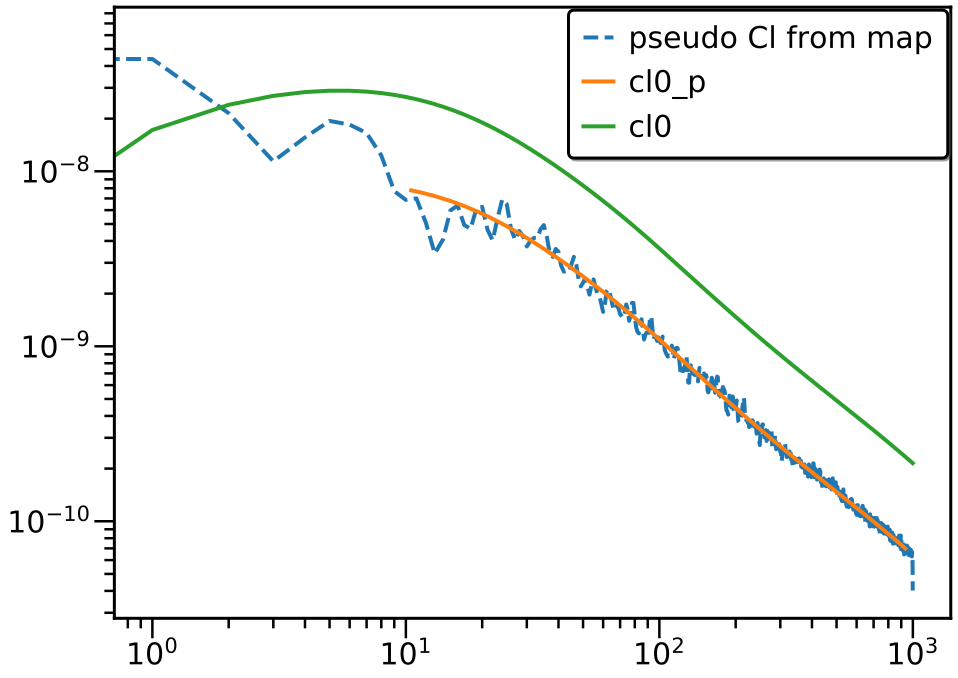

/usr/lib/python3.7/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/lib/python3.7/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
10:10:06 WARNING:findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


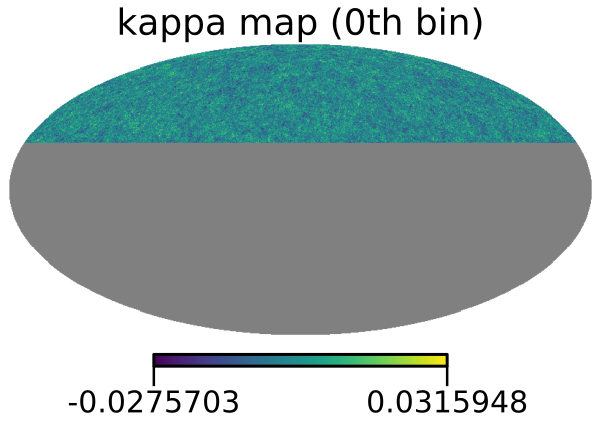

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in long_scalars
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


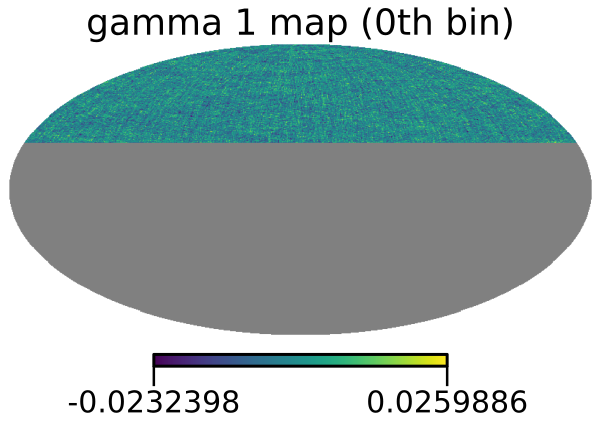

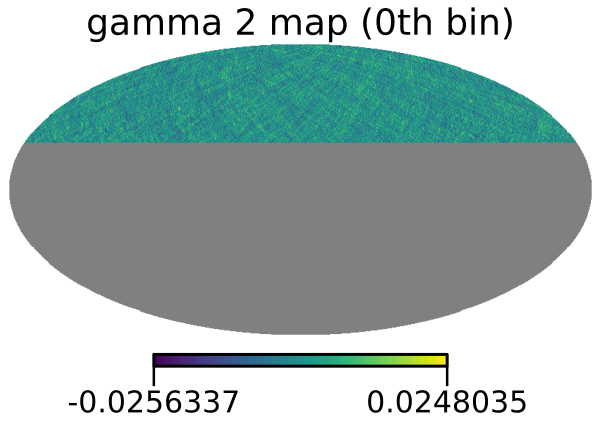

In [25]:
def kappa_map_gen(kappa, nside=nside):
    l = kappa.l
    l_bins = kappa.l_bins
    nu=2.*l+1.
    windows = {}
    masks = {}
    seen_indices = {}
    windows_one_indices = {}
    for i in range(n_source_bins):
        windows[i] = kappa.z_bins['kappa'][i]['window']
        masks[i] = windows[i]==hp.UNSEEN
        seen_indices[i] = np.where( windows[i]!=hp.UNSEEN )[0]
        windows_one_indices[i] = np.where( windows[i]==1.0 )[0]
        
    
    cl_map = hp.synfast(cl0,nside=nside,new=False,pol=False)
    
    for i in range(n_source_bins):
        cl_map[i]*=windows[i]
        cl_map[i][masks[i]] = hp.UNSEEN
    
    clp=hp.anafast(cl_map[0], lmax=max(l))
    
    plt.plot(l, clp, '--', label='pseudo Cl from map')
    plt.plot(lb, cl0_p[0], label='cl0_p')
    plt.plot(l, cl0[0], label='cl0')
    plt.loglog()
    plt.legend()
    plt.show()
    
    
    hp.mollview(cl_map[0], title='kappa map (0th bin)')
#     plt.savefig('kappa.pdf')
    plt.show()

    
    cl_sn = kappa_win.SN[corr_kk]
#     kappa_alm = hp.synalm(cl0,new=False) ## generate correlated kappa alm's
    kappa_alm = hp.map2alm(cl_map,pol=False, lmax=max(l)) ## generate correlated kappa alm's, with window/mask
    
    for i in range(n_source_bins):
        kappa_alm[i] += hp.synalm(cl_sn[:,i,i]) ## add the noise map
        
        
    trans_factor = [-np.sqrt( (li+2)*(li-1)/(li*(li+1))) for li in l   ] 
    trans_factor[0] = 0.
    trans_factor[1] = 0.
    
    gamma_alm = []
    for i in range(n_source_bins):
        gamma_alm.append(hp.sphtfunc.almxfl(kappa_alm[i], trans_factor))
        #sukhdeep: This conversion should ideally be done on full-sky kappa, before the window is applied. Otherwise shear may have some bias from the window.
            #     If you like, you can actually quantify this bias and show a plot discussing the effects of window on mass maps people usually make (though I believe their algorithms do try to
            #     account for it. )
    
    corr_config = {'min_sep':3., 'max_sep':600, 'nbins':10, 'sep_units':'arcmin'}
    
    k_map, g1_map, g2_map = hp.sphtfunc.alm2map( (kappa_alm[0],gamma_alm[0],kappa_alm[0]*0 ), nside=nside,pol=True  )
    g1_map[masks[0]] = hp.UNSEEN
    g2_map[masks[0]] = hp.UNSEEN
    
    hp.mollview(g1_map, title='gamma 1 map (0th bin)')
#     plt.savefig('g1.pdf')
    plt.show()

    hp.mollview(g2_map, title='gamma 2 map (0th bin)')
#     plt.savefig('g2.pdf')
    plt.show()
    
    
    ###################################
    ##   GG correlation
    ###################################
    theta, phi = hp.pix2ang(nside, seen_indices[0])
    ra = np.degrees(np.pi*2.-phi)
    dec = -np.degrees(theta-np.pi/2.)
    g1 = g1_map[seen_indices[0]]
    g2 = g2_map[seen_indices[0]]
    
    cat = treecorr.Catalog(ra=ra, dec=dec, g1=g1, g2=g2, ra_units='deg', dec_units='deg')
    gg = treecorr.GGCorrelation(**corr_config)
    gg.process(cat)
    
    
    ####################################
    ##  NN correlation (unit windows)
    ####################################
    theta_w, phi_w = hp.pix2ang(nside, windows_one_indices[0])
    ra_w = np.degrees(np.pi*2.-phi_w)
    dec_w = -np.degrees(theta_w-np.pi/2.)
    cat_win = treecorr.Catalog(ra=ra_w, dec=dec_w, ra_units='deg', dec_units='deg')
    cat_random = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg')

    dd = treecorr.NNCorrelation(**corr_config)
    rr = treecorr.NNCorrelation(**corr_config)
    dr = treecorr.NNCorrelation(**corr_config)
    
    dd.process(cat_win)
    rr.process(cat_random)
    dr.process(cat_win, cat_random)
    
    xi,varxi = dd.calculateXi(rr,dr)
    
    
    #######################################
    ##  KK correlation
    #######################################
    k = cl_map[0][seen_indices[0]]
    cat_kk = cat = treecorr.Catalog(ra=ra, dec=dec, k=k, ra_units='deg', dec_units='deg')
    kk = treecorr.KKCorrelation(**corr_config)
    kk.process(cat_kk)
    
    
    return (gg.rnom, gg.xip, gg.xim), (dd.rnom, xi), (kk.rnom, kk.xi), clp
    
    


res = kappa_map_gen(kappa_win, nside=nside)

In [26]:
print(res)
gg_res = res[0]
nn_res = res[1]
kk_res = res[2]

print(kappa_win.z_bins['kappa'][0]['window'])

((array([  3.90996396,   6.64164646,  11.28180928,  19.16380545,
        32.55253037,  55.29524063,  93.92706501, 159.54887691,
       271.0171357 , 460.36229941]), array([6.02040259e-05, 4.47383879e-05, 2.03701098e-05, 6.71392312e-06,
       6.52566892e-06, 3.61355941e-06, 1.87018091e-06, 8.22722004e-07,
       2.87598627e-07, 7.33588694e-08]), array([1.08521288e-07, 6.83781173e-07, 4.01054139e-06, 1.15159361e-05,
       6.09588292e-06, 3.46923956e-06, 2.08863396e-06, 1.28620404e-06,
       8.11539639e-07, 5.03771248e-07])), (array([  3.90996396,   6.64164646,  11.28180928,  19.16380545,
        32.55253037,  55.29524063,  93.92706501, 159.54887691,
       271.0171357 , 460.36229941]), array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.86737965e-08,  3.30213396e-08, -6.58176973e-09, -1.71385566e-08,
        5.14711919e-09,  0.00000000e+00])), (array([  3.90996396,   6.64164646,  11.28180928,  19.16380545,
        32.55253037,  55.29524063,  93.9270650

In [27]:
clp = res[3]

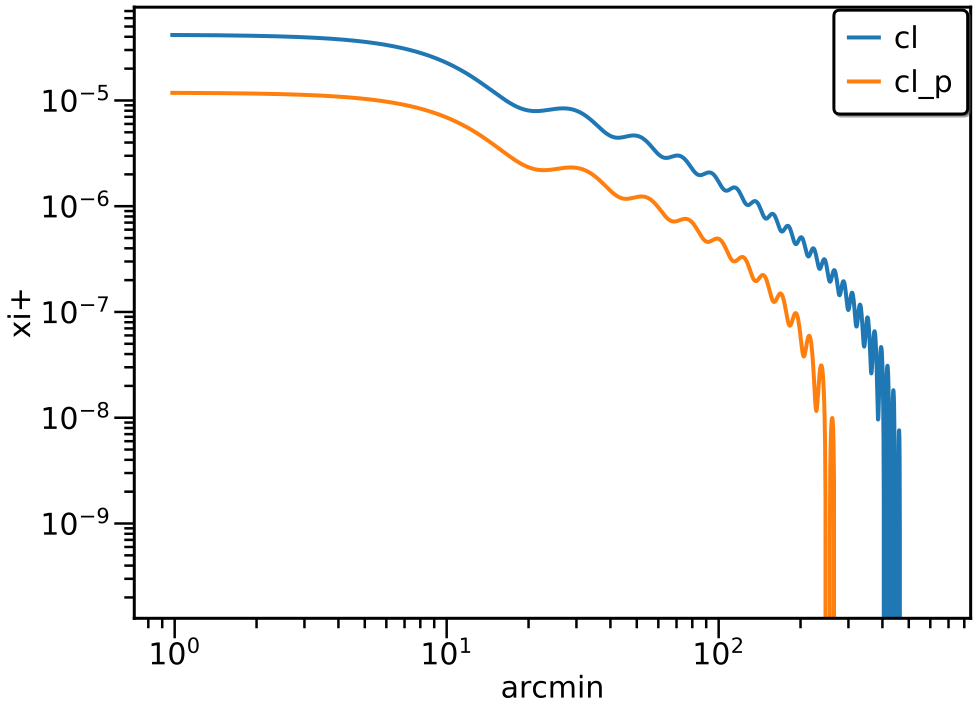

In [28]:
th, w = WT_L.projected_correlation(l_cl=l, cl=cl0[0], m1_m2=(2,2))
th, wm = WT_L.projected_correlation(l_cl=l, cl=cl0[0], m1_m2=(2,-2))



th_p, w_p =  WT_L.projected_correlation(l_cl=lb, cl=cl0_p[0], m1_m2=(2,2))
th_p, w_p_sim = WT_L.projected_correlation(l_cl=l, cl=clp, m1_m2=(2,2))

plt.plot(th/d2r*60, w, label='cl')
plt.plot(th_p/d2r*60, w_p, label='cl_p')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('arcmin')
plt.ylabel('xi+')
plt.show()

Healpix resolution with nside=1024 :  3.435486411817406 arcmin


NameError: name 'w_win' is not defined

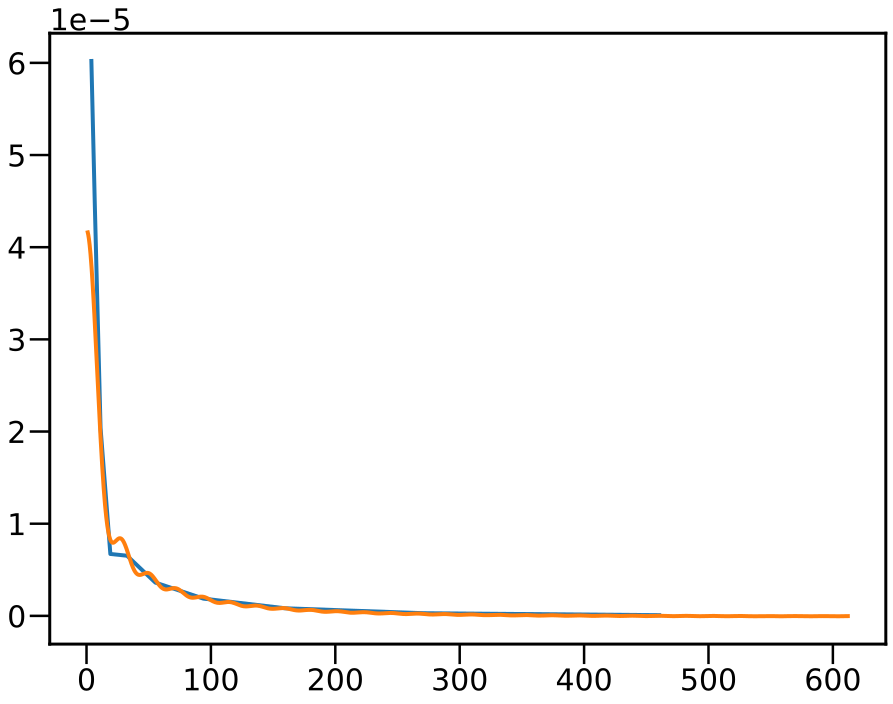

In [29]:
print("Healpix resolution with nside={} :  {} arcmin".format(nside, hp.nside2resol(nside, arcmin = True)))

plt.plot(gg_res[0], gg_res[1], label='sim')
plt.plot(th/d2r*60., w, '-', label='wigner (cl)')
plt.plot(th_p/d2r*60., w_p_sim/w_win, '-', label='wigner (cl_p)')

plt.title('xi+ (0,0)')
plt.xlabel('arcmin')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(gg_res[0], gg_res[2])
plt.plot(th/d2r*60., wm, '-', label='wigner (cl)')
plt.title('xi- (0,0)')
plt.xlabel('arcmin')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(kk_res[0], kk_res[1])
plt.title('<KK> (0,0)')
plt.xlabel('arcmin')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(nn_res[0],nn_res[1])
plt.title('xi of window : (DD-2DR+RR)/RR')
plt.xlabel('arcmin')
plt.xscale('log')
plt.show()

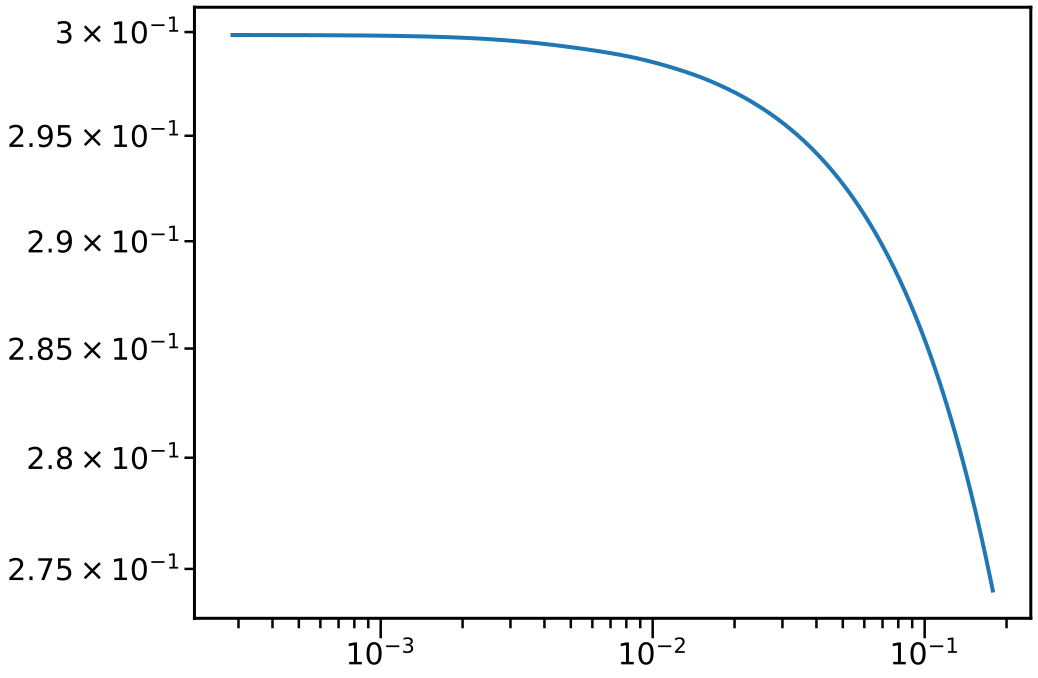

In [30]:
cl_win = hp.anafast(kappa_win.z_bins['kappa'][0]['window'], lmax=max(l))
th, w_win = WT_L.projected_correlation(l_cl=l, cl=cl_win,  m1_m2=(0,0))

plt.plot(th, w_win)
plt.loglog()
plt.show()